# Using LDA for Document Recommendation


PLSI defines:

* A topic distribution **per document**: $p(z \mid d)$
* A word distribution **per topic**: $p(w \mid z)$

But **the document–topic distributions are just model parameters**, one vector per document.

### Generative process (PLSI):

For each word token in a document:

1. Draw a topic $z_i \sim p(z \mid d)$
2. Draw a word $w_i \sim p(w \mid z_i)$

👉 **No prior** on document-topic distributions.
👉 The number of parameters grows with the number of documents.

---

## **LDA**

LDA is a fully generative document model.

LDA defines:

* For each document:
  A topic distribution drawn from a **Dirichlet prior**:
  $\theta_d \sim \text{Dirichlet}(\alpha)$
* For each topic:
  A word distribution drawn from a Dirichlet prior:
  $$
  \phi_z \sim \text{Dirichlet}(\beta)
  $$

### Generative process (LDA):

For each document:

1. Draw topic mixture $\theta_d \sim \text{Dirichlet}(\alpha)$
   For each word token:
2. Draw topic $z_i \sim \theta_d$
3. Draw word $w_i \sim \phi_{z_i}$

👉 **Has priors over distributions**, making it a complete generative model.
👉 Number of parameters is independent of number of documents.

---

# **2. Key Differences**

## **(a) PLSI is not a fully generative model**

* It defines $p(w \mid d)$ only for documents in the training set.
* It cannot naturally assign likelihoods to new documents without extending the parameter set.

**LDA *is* fully generative** and can assign probabilities to new documents.

## **(b) Parameter growth**
V = # of words, K = # topics, D = # documents
* PLSI: $O(D \times K + K \times V)$
* LDA: $O(K \times V)$
---

## **(c) Prediction on unseen documents**

* PLSI: Needs new EM optimization for new documents (folding-in).
* LDA: Just infer posterior $\theta_d$ using the learned $\phi_z$.

---


This notebook demonstrates how to use **Latent Dirichlet Allocation (LDA)** to recommend similar documents. We'll explore three different approaches:

1. **Standard LDA**: A single LDA model trained on all documents
2. **Conditional LDA**: Separate LDA models for each document category
3. **Average Alpha LDA**: A hybrid approach using averaged Dirichlet parameters

The goal is to compare how well each approach can find relevant documents from the training set when given a test document, based on their topic representations.

---

In [1]:
import numpy as np 
from numpy.random import RandomState
import os
import re
import time
import pandas as pd

import matplotlib.pyplot as plt

from dmx.stats import * 
from dmx.utils.estimation import iterate, partition_data
import dmx.utils.optsutil as ops
import dmx.utils.vector as vec


PATH_TO_DATA = "../data"

## Setup: Import Libraries and Load Data

We'll start by importing the necessary libraries and loading our Wikipedia dataset.

In [2]:
def load_wiki_data():
    """
    Load and preprocess Wikipedia example data for topic modeling.
    
    This function loads text files from the wiki_example directory, removes stop words,
    and partitions the data into training and test sets (90/10 split).
    
    Returns:
        tuple: A tuple containing:
            - data (list): A list of two elements [train_data, test_data], where each
                          element is a list of tuples (document_type, word_list).
            - words (list): Sorted list of unique words across all documents.
            - doc_types (list): Sorted list of unique document types (categories).
    
    Notes:
        - Requires PATH_TO_DATA to be set to the parent directory of 'wiki_example'.
        - Uses MALLET stop words for filtering.
        - Random seed is fixed to 1 for reproducibility.
    """
    
    # Initialize random state for reproducible data splitting
    rng = np.random.RandomState(1)
    pset = [0.9, 0.1]  # 90% train, 10% test split
    
    # Load stop words from MALLET stop words list
    sword = set([''])
    fin   = open(os.path.join(PATH_TO_DATA, 'stop_words', 'mallet.txt'), 'rt')
    sword = sword.union(fin.read().split('\n'))
    fin.close()

    # Get all .txt files from wiki_example directory
    wiki_loc = os.path.join(PATH_TO_DATA, 'wiki_example')
    # Create list of (document_type, file_path) tuples
    files    = [(u.split('.txt')[0].lower(), os.path.join(wiki_loc,u)) for u in filter(lambda v: v.endswith('.txt'), os.listdir(wiki_loc))]
    
    # Read files and filter out stop words
    # For each file, read lines and remove stop words from each line
    data     = [list(map(lambda u: (f[0], list(filter(lambda v: v not in sword, u.split(' ')))), ops.text_file(f[1]))) for f in files]
    
    # Partition each document's data into train/test sets (90/10)
    data     = [partition_data(u, [0.9,0.1], rng) for u in data]
    
    # Flatten and reorganize: create separate lists for train (index 0) and test (index 1)
    data     = [ops.flat_map(lambda x: x, [u[i] for u in data]) for i in range(len(pset))]
    
    # Remove any documents with empty word lists
    data     = [list(filter(lambda u: len(u[1]) > 0, v)) for v in data]
    
    # Extract vocabulary: all unique words across all documents
    words = sorted(set([u for q in data for v in q for u in v[1]]))
    
    # Extract document types (categories) from filenames
    doc_types = sorted(set(u[0] for u in files))
    
    return data, words, doc_types

In [3]:
data, words, doc_types = load_wiki_data()
print('#words = %d, #training docs = %d, #test docs = %d\n' % (len(words), len(data[0]), len(data[1])))
print("\n".join([f"Topic {i}: {x}" for i, x in enumerate(np.unique(doc_types).tolist())]))


#words = 19078, #training docs = 795, #test docs = 84

Topic 0: death
Topic 1: entertainment
Topic 2: food
Topic 3: investing
Topic 4: mathematics
Topic 5: medicine
Topic 6: politics
Topic 7: sports
Topic 8: war


### Preprocess the Data

Now we'll map words to integer indices and convert our data into the format needed for LDA training. We also create label arrays to track which category each document belongs to.

In [4]:
# Create a mapping from words to integer indices
word_map = dict()

# Convert word lists to integer indices for both train and test sets
data     = [[(u[0], ops.map_to_integers(u[1], word_map)) for u in v] for v in data]

# Convert to (document_type, [(word_id, count)]) format - counting word occurrences
data_cnt = [[(u[0], list(ops.count_by_value(u[1]).items())) for u in v] for v in data]

# Create mappings between document types and integer labels
doc_type_map = dict(zip(doc_types, range(len(doc_types))))
word_map_inv = ops.get_inv_map(word_map)

# Extract the true category labels for train and test documents
train_labels = np.asarray([doc_type_map[u[0]] for u in data_cnt[0]], dtype=object)
test_labels  = np.asarray([doc_type_map[u[0]] for u in data_cnt[1]], dtype=object)

## Approach 1: Standard LDA for Document Recommendation

We'll train a standard LDA model on all documents, regardless of their category. This model will learn 10 topics that capture the main themes across the entire corpus.

In [5]:
# Set number of topics to discover
num_topics_f = 10
rng = np.random.RandomState(1)

# Define an estimator for word distributions within each topic
# Uses categorical distribution over all words in vocabulary
word_est = IntegerCategoricalEstimator(min_val=0, max_val=(len(word_map)-1), pseudo_count=0.001)

# Create LDA estimator with 10 topics
# gamma_threshold controls convergence criteria for variational inference
est_f = LDAEstimator([word_est]*num_topics_f, gamma_threshold=1.0e-2)

# Encode training data in the format expected by LDA
enc_train_data = seq_encode(data=[u[1] for u in data_cnt[0]], estimator=est_f)

# Initialize the model with random topic assignments
model_f = seq_initialize(enc_data=enc_train_data, estimator=est_f, rng=rng, p=0.10)

### Train the Standard LDA Model

We'll run the EM algorithm for up to 200 iterations to learn the topic-word distributions and document-topic distributions. Our likelihood is approximated, so are going to use the `iterate` function here in place of the standard `optimize` call.

In [6]:
# Train the LDA model using iterative EM algorithm
# Prints progress every 20 iterations
model_f = iterate(
    data=None, 
    enc_data=enc_train_data, 
    estimator=est_f, 
    max_its=200,                # Maximum number of iterations
    prev_estimate=model_f,      # Starting point (initialized model)
    print_iter=20               # Print progress every 20 iterations
)

Iteration 20	 E[dT]=0.073958.
Iteration 40	 E[dT]=0.067257.
Iteration 40	 E[dT]=0.067257.
Iteration 60	 E[dT]=0.064256.
Iteration 60	 E[dT]=0.064256.
Iteration 80	 E[dT]=0.062950.
Iteration 80	 E[dT]=0.062950.
Iteration 100	 E[dT]=0.061805.
Iteration 100	 E[dT]=0.061805.
Iteration 120	 E[dT]=0.060767.
Iteration 120	 E[dT]=0.060767.
Iteration 140	 E[dT]=0.060208.
Iteration 140	 E[dT]=0.060208.
Iteration 160	 E[dT]=0.060178.
Iteration 160	 E[dT]=0.060178.
Iteration 180	 E[dT]=0.059917.
Iteration 180	 E[dT]=0.059917.
Iteration 200	 E[dT]=0.059542.
Iteration 200	 E[dT]=0.059542.


### Examine the Learned Topics

Let's look at the top words in each topic to understand what themes the model discovered.

In [7]:
# Extract the learned topics from the trained model
topics = model_f.topics

# Display the top 10 words for each topic
for i in range(num_topics_f):
    # Sort words by probability (highest first)
    sidx = np.argsort(-topics[i].log_p_vec)
    # Format top words with their probabilities
    top_words = ', '.join(['%s (%f)'%(word_map_inv[j], np.exp(topics[i].log_p_vec[j])) for j in sidx[:10]])
    print('Topic %d : %s\n'%(i, top_words))

Topic 0 : warfare (0.068699), military (0.065054), heart (0.020803), information (0.017527), war (0.016155), gender (0.015681), weapons (0.015480), television (0.014988), strategic (0.014073), blood (0.013877)

Topic 1 : food (0.076596), species (0.017361), plants (0.016848), cells (0.015647), salt (0.012568), cherry (0.010410), life (0.010134), plant (0.009998), fitness (0.008411), animals (0.008279)

Topic 2 : war (0.079818), political (0.057659), sports (0.038884), government (0.037243), democracy (0.021843), strategy (0.013753), state (0.013359), rights (0.013044), states (0.010967), power (0.010950)

Topic 3 : disease (0.043174), medical (0.039142), death (0.028964), health (0.028318), heart (0.018351), water (0.017517), research (0.016143), blood (0.015872), skin (0.012294), diagnosis (0.012218)

Topic 4 : music (0.035914), oxygen (0.028780), anxiety (0.024871), sleep (0.018177), milk (0.013975), lungs (0.010407), mortis (0.009604), lung (0.008335), breathing (0.008172), fermenta

### Evaluate Standard LDA Recommendation Performance

Now we'll use the trained LDA model to represent documents as topic distributions and evaluate how well it can recommend similar documents.

In [8]:
def get_score_mat(train_locs, test_locs, train_labels, test_labels):
    """
    Evaluate document recommendation performance using topic representations.
    
    For each test document, we find the most similar training documents based on
    their topic distributions and track how many matches have the same category.
    
    Args:
        train_locs: Topic distributions for training documents (num_train x num_topics)
        test_locs: Topic distributions for test documents (num_test x num_topics)
        train_labels: True category labels for training documents
        test_labels: True category labels for test documents
    
    Returns:
        smat: Score matrix (num_test x num_train) where smat[i,j] = cumulative count
              of how many of the top j+1 recommendations match test doc i's category
    """
    
    # Normalize topic distributions to create probability distributions
    train_locs /= train_locs.sum(axis=1, keepdims=True)
    test_locs /= test_locs.sum(axis=1, keepdims=True)

    # Compute similarity matrix: dot product between test and train topic distributions
    # Higher values = more similar topic distributions
    cmat = np.dot(test_locs, train_locs.T)
    
    # Initialize score matrix
    smat = np.zeros(cmat.shape)
    
    # Sort training docs by similarity (highest first) for each test doc
    sidx = np.argsort(-cmat, axis=1)

    # For each test document, compute cumulative matches in ranked list
    for i in range(len(test_labels)):
        # Cumulative sum: how many matches found in top-k recommendations
        smat[i,:] = np.cumsum(train_labels[sidx[i,:]] == test_labels[i])
        
    return smat

In PLSI, weights are estimated for documents seen at training time. With LDA, we can estimate posteriors document weights for unseen documents. This allows us to generalize to documents outside of our training set. We can compute the training and test document embeddings then search for similar documents in the training set for each test point.

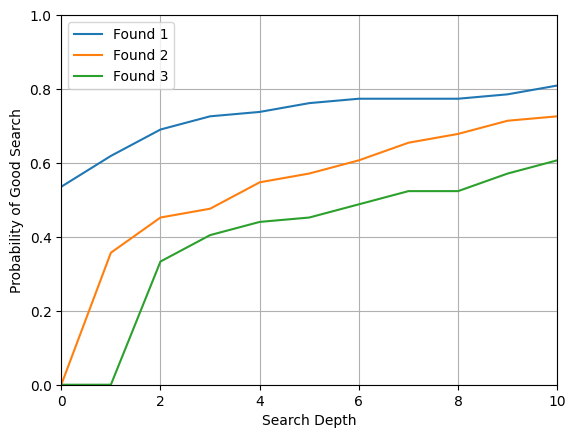

In [9]:
# Compute topic distributions for training documents
train_locs_f = model_f.seq_posterior(model_f.dist_to_encoder().seq_encode([u[1] for u in data_cnt[0]]))

# Compute topic distributions for test documents
test_locs_f  = model_f.seq_posterior(model_f.dist_to_encoder().seq_encode([u[1] for u in data_cnt[1]]))

# Evaluate recommendation performance
smat_f = get_score_mat(train_locs_f, test_locs_f, train_labels, test_labels)

# Plot the probability of finding relevant documents at different search depths
fig, ax = plt.subplots()

# Plot curves for finding 1, 2, or 3 relevant documents
ax.plot([(smat_f[:,i] >= 1).sum()/smat_f.shape[0] for i in range(11)], label='Found 1')
ax.plot([(smat_f[:,i] >= 2).sum()/smat_f.shape[0] for i in range(11)], label='Found 2')
ax.plot([(smat_f[:,i] >= 3).sum()/smat_f.shape[0] for i in range(11)], label='Found 3')

ax.set_xlabel('Search Depth')
ax.set_ylabel('Probability of Good Search')
ax.set_ylim(0,1)
ax.set_xlim(0,10)
ax.legend()
ax.grid();

The plot above suggests that the top 10 documents pulled up contained 1, 2, and 3 relevant documents 81%, 75%, and 61% of the time respectively.

## Approach 2: Conditional LDA for Document Recommendation

Instead of one model for all documents, we'll train a **separate LDA model for each document category**. This allows each category to have its own Dirichlet prior parameters (alpha values). By passing `keys=(None, "topics")` to `LDAEstimator`, we ensure that each LDAModel differs only by the estimation of $\alpha$. 

This conditional approach can capture category-specific patterns better than a single global model.

In [10]:
# Set up conditional LDA: one LDA model per document category
num_topics = 10
rng = np.random.RandomState(1)

# Word distribution estimator (shared across all topics and categories)
est0 = IntegerCategoricalEstimator(min_val=0, max_val=(len(word_map)-1), pseudo_count=0.001)

# LDA estimator for each category (10 topics per category)
est1 = LDAEstimator([est0]*num_topics, keys=(None, "topics"), gamma_threshold=1.0e-2)

# Conditional estimator: maps each document type to its own LDA model
est = ConditionalDistributionEstimator({tt:est1 for tt in doc_types})

# Encode training data (includes document category information)
enc_train_coupled_data = seq_encode(data=data_cnt[0], estimator=est)

# Initialize conditional model with random topic assignments
model = seq_initialize(enc_data=enc_train_coupled_data, estimator=est, rng=rng, p=0.10)

### Examine Topics from One Category

Let's look at the topics learned for one specific document category to see how they differ from the global topics.

### Train the Conditional LDA Model

**Important**: We need to train the conditional model just like we did for the standard LDA. Without training, the model only has random initializations and won't perform well.

In [11]:
# Train the conditional LDA model using iterative EM algorithm
model = iterate(
    data=None,
    enc_data=enc_train_coupled_data,
    estimator=est,
    max_its=200,
    prev_estimate=model,
    print_iter=20
)

Iteration 20	 E[dT]=0.085325.
Iteration 40	 E[dT]=0.079841.
Iteration 40	 E[dT]=0.079841.
Iteration 60	 E[dT]=0.078794.
Iteration 60	 E[dT]=0.078794.
Iteration 80	 E[dT]=0.078162.
Iteration 80	 E[dT]=0.078162.
Iteration 100	 E[dT]=0.077816.
Iteration 100	 E[dT]=0.077816.
Iteration 120	 E[dT]=0.078198.
Iteration 120	 E[dT]=0.078198.
Iteration 140	 E[dT]=0.077159.
Iteration 140	 E[dT]=0.077159.
Iteration 160	 E[dT]=0.076300.
Iteration 160	 E[dT]=0.076300.
Iteration 180	 E[dT]=0.075874.
Iteration 180	 E[dT]=0.075874.
Iteration 200	 E[dT]=0.075478.
Iteration 200	 E[dT]=0.075478.


In [12]:
# Extract topics from the first document category's LDA model
topics = model.dmap[doc_types[0]].topics

# Display top words for each topic in this category
for i in range(num_topics):
    sidx = np.argsort(-topics[i].log_p_vec)
    top_words = ', '.join(['%s (%f)'%(word_map_inv[j], np.exp(topics[i].log_p_vec[j])) for j in sidx[:10]])
    print('Topic %d : %s\n'%(i, top_words))

Topic 0 : disease (0.054398), medical (0.049317), energy (0.046902), health (0.035677), death (0.035589), research (0.021960), loss (0.015458), diagnosis (0.015395), media (0.014746), genetics (0.014058)

Topic 1 : investment (0.045209), film (0.044769), finance (0.026091), festival (0.022641), capital (0.020988), return (0.019045), interest (0.018431), stock (0.013654), company (0.012366), financial (0.011266)

Topic 2 : blood (0.093259), heart (0.054397), economic (0.029719), population (0.025562), growth (0.022686), skin (0.019421), rate (0.019024), market (0.018298), demand (0.016600), inflation (0.015293)

Topic 3 : greek (0.021182), bc (0.018350), species (0.011167), cherry (0.010930), ancient (0.010927), mathematics (0.009602), period (0.009104), plant (0.008853), egypt (0.008524), matter (0.008331)

Topic 4 : democracy (0.029914), city (0.016579), calculus (0.015522), fun (0.013751), religions (0.011227), magpie (0.009645), religion (0.008853), voting (0.008814), eeg (0.008477)

### Visualize Category Similarity

Each category has its own Dirichlet prior (alpha parameters). We can visualize how similar different categories are by computing the correlation between their alpha vectors.

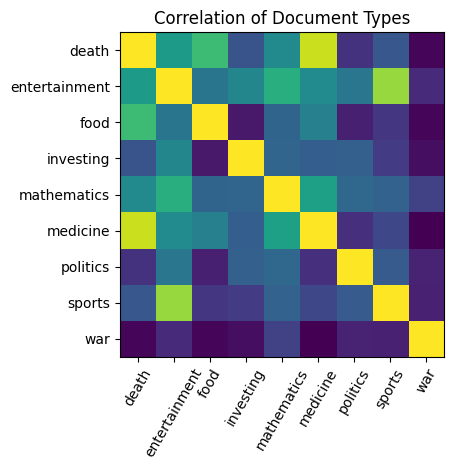

In [13]:
# Extract alpha (Dirichlet prior) parameters for each category
alpha_vals = [(k, v.alpha) for k,v in model.dmap.items()]
type_vec   = [u[0] for u in alpha_vals]
alpha_vals = np.asarray([u[1] for u in alpha_vals])

# Normalize alpha vectors for comparison
alpha_vals = alpha_vals/np.sqrt((alpha_vals*alpha_vals).sum(axis=1,keepdims=True))

# Create correlation heatmap
fig, ax = plt.subplots()
ax.imshow(np.dot(alpha_vals, alpha_vals.T))
ax.set_yticks(range(len(type_vec)))
ax.set_yticklabels(type_vec)
ax.set_xticks(range(len(type_vec)))
ax.set_xticklabels(type_vec, rotation=60)
ax.set_title('Correlation of Document Types')
fig.tight_layout();

### Helper Functions for Conditional LDA Inference

For the conditional model, we need special functions to compute topic distributions:
- **Conditional posteriors**: For training docs, we know the category, so we use the corresponding LDA model
- **Marginal posteriors**: For test docs, we don't know the category, so we marginalize over all categories

In [14]:
def get_conditional_posteriors(model, wcnts):
    """
    Compute topic distributions when document categories are known.
    
    For each document, we use its known category to select the appropriate
    LDA model and compute the posterior topic distribution.
    
    Args:
        model: Conditional LDA model (one LDA per category)
        wcnts: List of (category, word_counts) tuples
    
    Returns:
        Array of topic distributions (one per document)
    """
    rv  = [None]*len(wcnts)
    idx = np.asarray([u[0] for u in wcnts], dtype=object)
    
    # For each category, process all documents of that type together
    for t,mm in model.dmap.items():
        # Find all documents of this category
        idxf = np.flatnonzero(idx == t)
        # Compute their topic distributions using this category's LDA
        temp_mat = mm.seq_posterior(mm.dist_to_encoder().seq_encode([wcnts[i][1] for i in idxf]))
                
        for i,j in enumerate(idxf):
            rv[j] = temp_mat[i,:]

    return np.asarray(rv)       
            
def get_marginal_posteriors(model, wcnts):
    """
    Compute topic distributions when document categories are unknown.
    
    For test documents, we don't know the true category. We compute the 
    posterior under each category's LDA, weight by the likelihood of each
    category, and marginalize to get the overall topic distribution.
    
    Args:
        model: Conditional LDA model (one LDA per category)
        wcnts: List of word count dictionaries (no category labels)
    
    Returns:
        Array of marginalized topic distributions
    """
    ll_list  = []
    top_list = []
    tlist    = []
    
    # For each category, compute likelihoods and topic posteriors
    for t,mm in model.dmap.items():
        tlist.append(t)
        enc_data = mm.dist_to_encoder().seq_encode(wcnts)
        # Log-likelihood of documents under this category
        ll_list.append(mm.seq_log_density(enc_data))
        # Topic distributions under this category
        top_list.append(mm.seq_posterior(enc_data))

    # Convert log-likelihoods to category probabilities
    ll_list = np.asarray(ll_list)
    max_ll = ll_list.max(axis=0, keepdims=True)
    topic_prob = np.exp(ll_list - max_ll)
    topic_prob /= topic_prob.sum(axis=0, keepdims=True)
    
    # Weight topic distributions by category probabilities
    for i in range(len(tlist)):
        top_list[i] *= topic_prob[i,None,:].T
    
    # Marginalize: sum over all categories
    rv = top_list[0]
    for i in range(1,len(tlist)):
        rv += top_list[i]
        
    return rv

## Approach 3: Average Alpha LDA

As a middle ground, we'll create a single LDA model using the **average of all category-specific alpha parameters**. This captures some category-specific information while maintaining a simpler single-model structure.

In [15]:
# Compute the mean alpha across all categories
mean_alpha = np.mean(np.asarray([v.alpha for v in model.dmap.values()]), axis=0)

# Create a new LDA model using the averaged alpha but shared topics
mean_model = LDADistribution(model.dmap[doc_types[0]].topics, mean_alpha)

### Compute Topic Distributions for All Three Approaches

Now we'll compute topic representations for training and test documents using all three methods.

In [16]:
# Conditional LDA: Use category-specific models
train_locs = get_conditional_posteriors(model, data_cnt[0])
test_locs  = get_marginal_posteriors(model, [u[1] for u in data_cnt[1]])

In [17]:
# Average Alpha LDA: Use model with averaged alpha parameters
train_locs_a = mean_model.seq_posterior(mean_model.dist_to_encoder().seq_encode([u[1] for u in data_cnt[0]]))
test_locs_a  = mean_model.seq_posterior(mean_model.dist_to_encoder().seq_encode([u[1] for u in data_cnt[1]]))

### Compute Recommendation Scores

Calculate the score matrices for all three approaches so we can compare their performance.

In [18]:
# Compute score matrices for conditional and average alpha approaches
smat = get_score_mat(train_locs, test_locs, train_labels, test_labels)
smat_a = get_score_mat(train_locs_a, test_locs_a, train_labels, test_labels)

## Final Comparison: All Three Approaches

Let's compare all three LDA approaches to see which performs best for document recommendation. The plot shows the probability of finding at least one relevant document (from the same category) as we search deeper into the ranked recommendations.

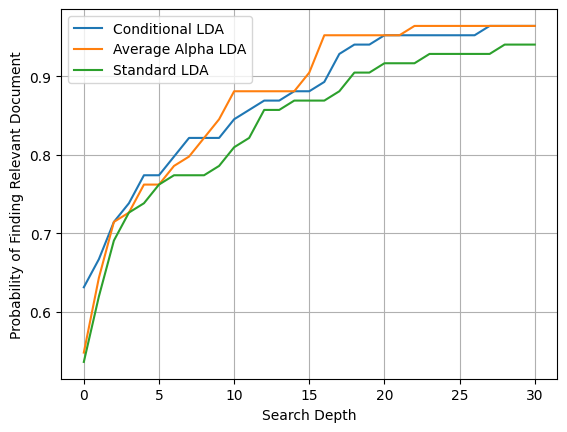

In [21]:
# Create comparison plot of all three approaches
fig, ax = plt.subplots()

# Plot probability of finding at least 1 relevant document at each search depth
ax.plot([(smat[:,i] >= 1).sum()/smat.shape[0] for i in range(31)], label='Conditional LDA')
ax.plot([(smat_a[:,i] >= 1).sum()/smat.shape[0] for i in range(31)], label='Average Alpha LDA')
ax.plot([(smat_f[:,i] >= 1).sum()/smat.shape[0] for i in range(31)], label='Standard LDA')

ax.set_xlabel('Search Depth')
ax.set_ylabel('Probability of Finding Relevant Document')
ax.legend()
ax.grid();

## Interpretation of Results

- **Conditional LDA**: By learning separate topic structures for each category, it captures category-specific patterns and should achieve the best recommendation performance.

- **Average Alpha LDA**: Using averaged Dirichlet priors provides some category-awareness while keeping a single model, offering a compromise between the other two approaches.

- **Standard LDA** The single global model treats all documents the same, missing category-specific structure. It's good, but can't capture the nuances that conditional models provide in some cases. It still provides comparable performance with no apriori knowledge of the true document topics.

### Key Takeaway
For document recommendation tasks where documents have clear categories, **trained** conditional models that learn category-specific representations should significantly outperform global models. However, the standard LDA model performs quite well in comparison with less infomration and compute required. 